# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
import datetime
import os
os.getcwd()
from matplotlib.pyplot import imread

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Using TensorFlow backend.


In [3]:
#additional libraries imported for visual analysis
import matplotlib.pyplot as plt

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(os.getcwd()+"/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open(os.getcwd()+"/Project_data/val.csv").readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
img_size=60
no_of_images_in_folder=15
crop_value=0
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #image=image[crop_value:-crop_value,crop_value:-crop_value,:]
                    image=resize(image[:,:,:],(img_size,img_size),anti_aliasing=True)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/(np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/(np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/(np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batch_size=len(t)-(num_batches*batch_size)
        rem_batch_data = np.zeros((rem_batch_size,len(img_idx),img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        rem_batch_labels = np.zeros((rem_batch_size,5)) # batch_labels is the one hot representation of the output
        for folder in range(rem_batch_size): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder+(num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image=image[crop_value:-crop_value,crop_value:-crop_value,:]
                image=resize(image[:,:,:],(img_size,img_size),anti_aliasing=True)
                rem_batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/(np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))
                rem_batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/(np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
                rem_batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/(np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))
            rem_batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
        yield rem_batch_data, rem_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
import os
os.getcwd()

'D:\\upgrad\\gesturerecognition'

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = os.getcwd()+"/Project_data/train"
val_path = os.getcwd()+"/Project_data/val"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras import backend
backend.set_image_data_format('channels_last')

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model=Sequential()
model.add(Conv3D(8, kernel_size=(3,3,3),
                 activation='relu',
                 input_shape=(no_of_images_in_folder, img_size, img_size, 3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(16, kernel_size=(3,3,3),
                 activation='relu',
                 input_shape=(no_of_images_in_folder, img_size, img_size, 3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3),
                 activation='relu',
                 input_shape=(no_of_images_in_folder, img_size, img_size, 3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
# flatten and put a fully connected layer
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 60, 60, 8)     656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 8)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 30, 30, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 16)     3472      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 15, 15, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 15, 15, 32)     13856     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 7, 7, 32)      

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 60, 60, 8)     656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 8)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 30, 30, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 16)     3472      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 15, 15, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 15, 15, 32)     13856     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 7, 7, 32)      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
callbacks_list = [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50Source path =  D:\upgrad\gesturerecognition/Project_data/val ; batch size = 30

Source path =  D:\upgrad\gesturerecognition/Project_data/train ; batch size = 30
23/23 [==============================] - 110s 5s/step - loss: 1.6486 - categorical_accuracy: 0.1885 - val_loss: 1.6125 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-09-1400_32_19.302208/model-00001-1.65267-0.18854-1.61252-0.21000.h5
Epoch 2/50
23/23 [==============================] - 63s 3s/step - loss: 1.5945 - categorical_accuracy: 0.2594 - val_loss: 1.5909 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-09-1400_32_19.302208/model-00002-1.59993-0.25943-1.59086-0.31000.h5
Epoch 3/50
23/23 [==============================] - 64s 3s/step - loss: 1.6026 - categorical_accuracy: 0.2247 - val_loss: 1.6067 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-09-1400_32_19.302208/model-00003-1.60521-0.22474-1.60673-0.38000.h5
Epoch

Epoch 30/50
23/23 [==============================] - 67s 3s/step - loss: 0.2288 - categorical_accuracy: 0.9276 - val_loss: 0.4503 - val_categorical_accuracy: 0.8800

Epoch 00030: saving model to model_init_2020-09-1400_32_19.302208/model-00030-0.23671-0.92760-0.45031-0.88000.h5
Epoch 31/50
23/23 [==============================] - 66s 3s/step - loss: 0.2502 - categorical_accuracy: 0.9020 - val_loss: 0.0149 - val_categorical_accuracy: 0.8900

Epoch 00031: saving model to model_init_2020-09-1400_32_19.302208/model-00031-0.25800-0.90196-0.01488-0.89000.h5
Epoch 32/50
23/23 [==============================] - 66s 3s/step - loss: 0.2754 - categorical_accuracy: 0.9065 - val_loss: 0.1591 - val_categorical_accuracy: 0.9000

Epoch 00032: saving model to model_init_2020-09-1400_32_19.302208/model-00032-0.27440-0.90649-0.15907-0.90000.h5
Epoch 33/50
23/23 [==============================] - 66s 3s/step - loss: 0.2334 - categorical_accuracy: 0.9050 - val_loss: 0.1180 - val_categorical_accuracy: 0.890

# Plots for Visual Analysis

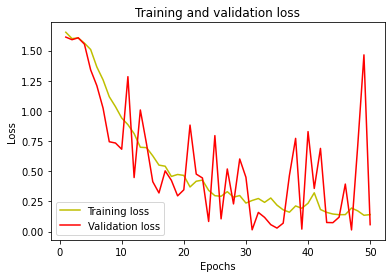

In [15]:
history_dropout=history
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

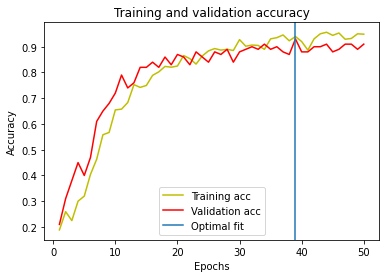

In [17]:
acc = history_dropout.history['categorical_accuracy']
val_acc = history_dropout.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.axvline(x=[39], label='Optimal fit')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Analysis and Inference

<b> Selecting model fit at epoch 39 which gives balanced accuracy of approximately 0.93.<br>
    <br>Additional Observations:<br>
    There is slight variation/sway in validation loss but it follows pattern for training loss and also reduces with more epochs